In [10]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecMonitor, VecFrameStack, DummyVecEnv

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

import sys
sys.path.append('../') #This is added so we can import from the source folder
from src.policies import ImpalaCNN

def make_procgen_env(env_name, num_envs=1, start_level=0, num_levels=0):
    def _init():
        
        return env
    return DummyVecEnv([_init] * num_envs)

env_name = "procgen:procgen-heist-v0"  



env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 



In [2]:
def load_model(model_path = '../model_1400_latest.pt'):
    observation_space = env.observation_space
    action_space = env.action_space.n
    model = ImpalaCNN(observation_space, action_space)
    model.load_from_file(model_path, device="cpu")
    return model


In [3]:
@torch.no_grad()
def generate_action(model, observation):
    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

    model_output = model(observation)
    
    logits = model_output[0].logits  # discard the output of the critic in our actor critic network
    
    probabilities = torch.softmax(logits, dim=-1)
    
    action = torch.multinomial(probabilities, 1).item() 
    return action


In [14]:
import torch
import imageio


frames = []
observations =[]
def run_episode_and_save_as_gif(env, model, filepath='../gifs/run.gif', save_gif=False):

    observation = env.reset()
    done = False
    total_reward = 0
    

    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))  
        action = generate_action(model, observation)  
        observation, reward, done, info = env.step(action)
        total_reward += reward
        observations.append(observation)

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30) 

    return total_reward, frames 


save_gif_option = True  



In [16]:

model = load_model()

for episode in range(1):
    total_reward, _ = run_episode_and_save_as_gif(env, model, filepath=f'episode_mod_2_{episode+1}.gif', save_gif=save_gif_option)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")






Episode 1 finished with total reward: 10.0


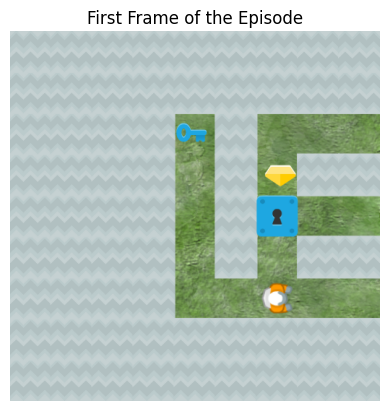

In [17]:
# Check if frames list is not empty
if frames:
    plt.imshow(frames[0])
    plt.title("First Frame of the Episode")
    plt.axis('off')  # Hide axis
    plt.show()
else:
    print("No frames captured.")

In [ ]:
import torch

activations = {}

def get_activation(name):
    def hook(model, input, output):
        # Initialize a placeholder for processed output
        processed_output = []
        
        for item in output:
            # Check if the item is a tensor and detach it
            if isinstance(item, torch.Tensor):
                processed_output.append(item.detach())
            # If the item is a Categorical, you might want to extract its logits or probs
            elif isinstance(item, torch.distributions.Categorical):
                processed_output.append(item.logits.detach())
            else:
                # Handle other types as necessary
                processed_output.append(item)
        
        # Save the processed output in the activations dictionary
        activations[name] = tuple(processed_output)
    return hook


model = load_model()

# Define a function to recursively register hooks based on a path
def register_hook_by_path(model, path, name):
    elements = path.split('.')
    for i, element in enumerate(elements):
        if '[' in element:
            # Splitting at '[' and removing the closing ']' to get the index
            base, index = element.replace(']', '').split('[')
            index = int(index)  # Convert index to integer
            model = getattr(model, base)[index]
        else:
            model = getattr(model, element)
        # If we are at the last element, register the hook
        if i == len(elements) - 1:
            model.register_forward_hook(get_activation(name))

# List of layer paths to hook, based on your initial list
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]

# Register hooks for each path
for path in layer_paths:
    register_hook_by_path(model, path, path.replace('.', '_'))

# Attach the hook to a specific layer, e.g., model.layer1
# model.register_forward_hook(get_activation('conv_seqs.0'))
# model.conv_seqs[0].conv.register_forward_hook(get_activation('conv_seqs.0.conv'))

# # Adjust the layer path to match the next layer you are interested in
# model.conv_seqs[1].max_pool2d.register_forward_hook(get_activation('max_pool2d'))

# for idx, layer in enumerate(model.conv_seqs):
#     if hasattr(layer, 'conv'):
#         # Construct a string that uniquely identifies the layer
#         layer_name = f'conv_seqs[{idx}].conv'
#         # Register the hook
#         layer.conv.register_forward_hook(get_activation(layer_name))
#     # Add similar checks for other types of layers or nested structures

# Run your data through the model
observation = torch.tensor(observations[0], dtype=torch.float32).unsqueeze(0)


output = model(observation)

# Now, activations['layer1'] contains the activations from layer1


No activations found for layer: max_pool2d


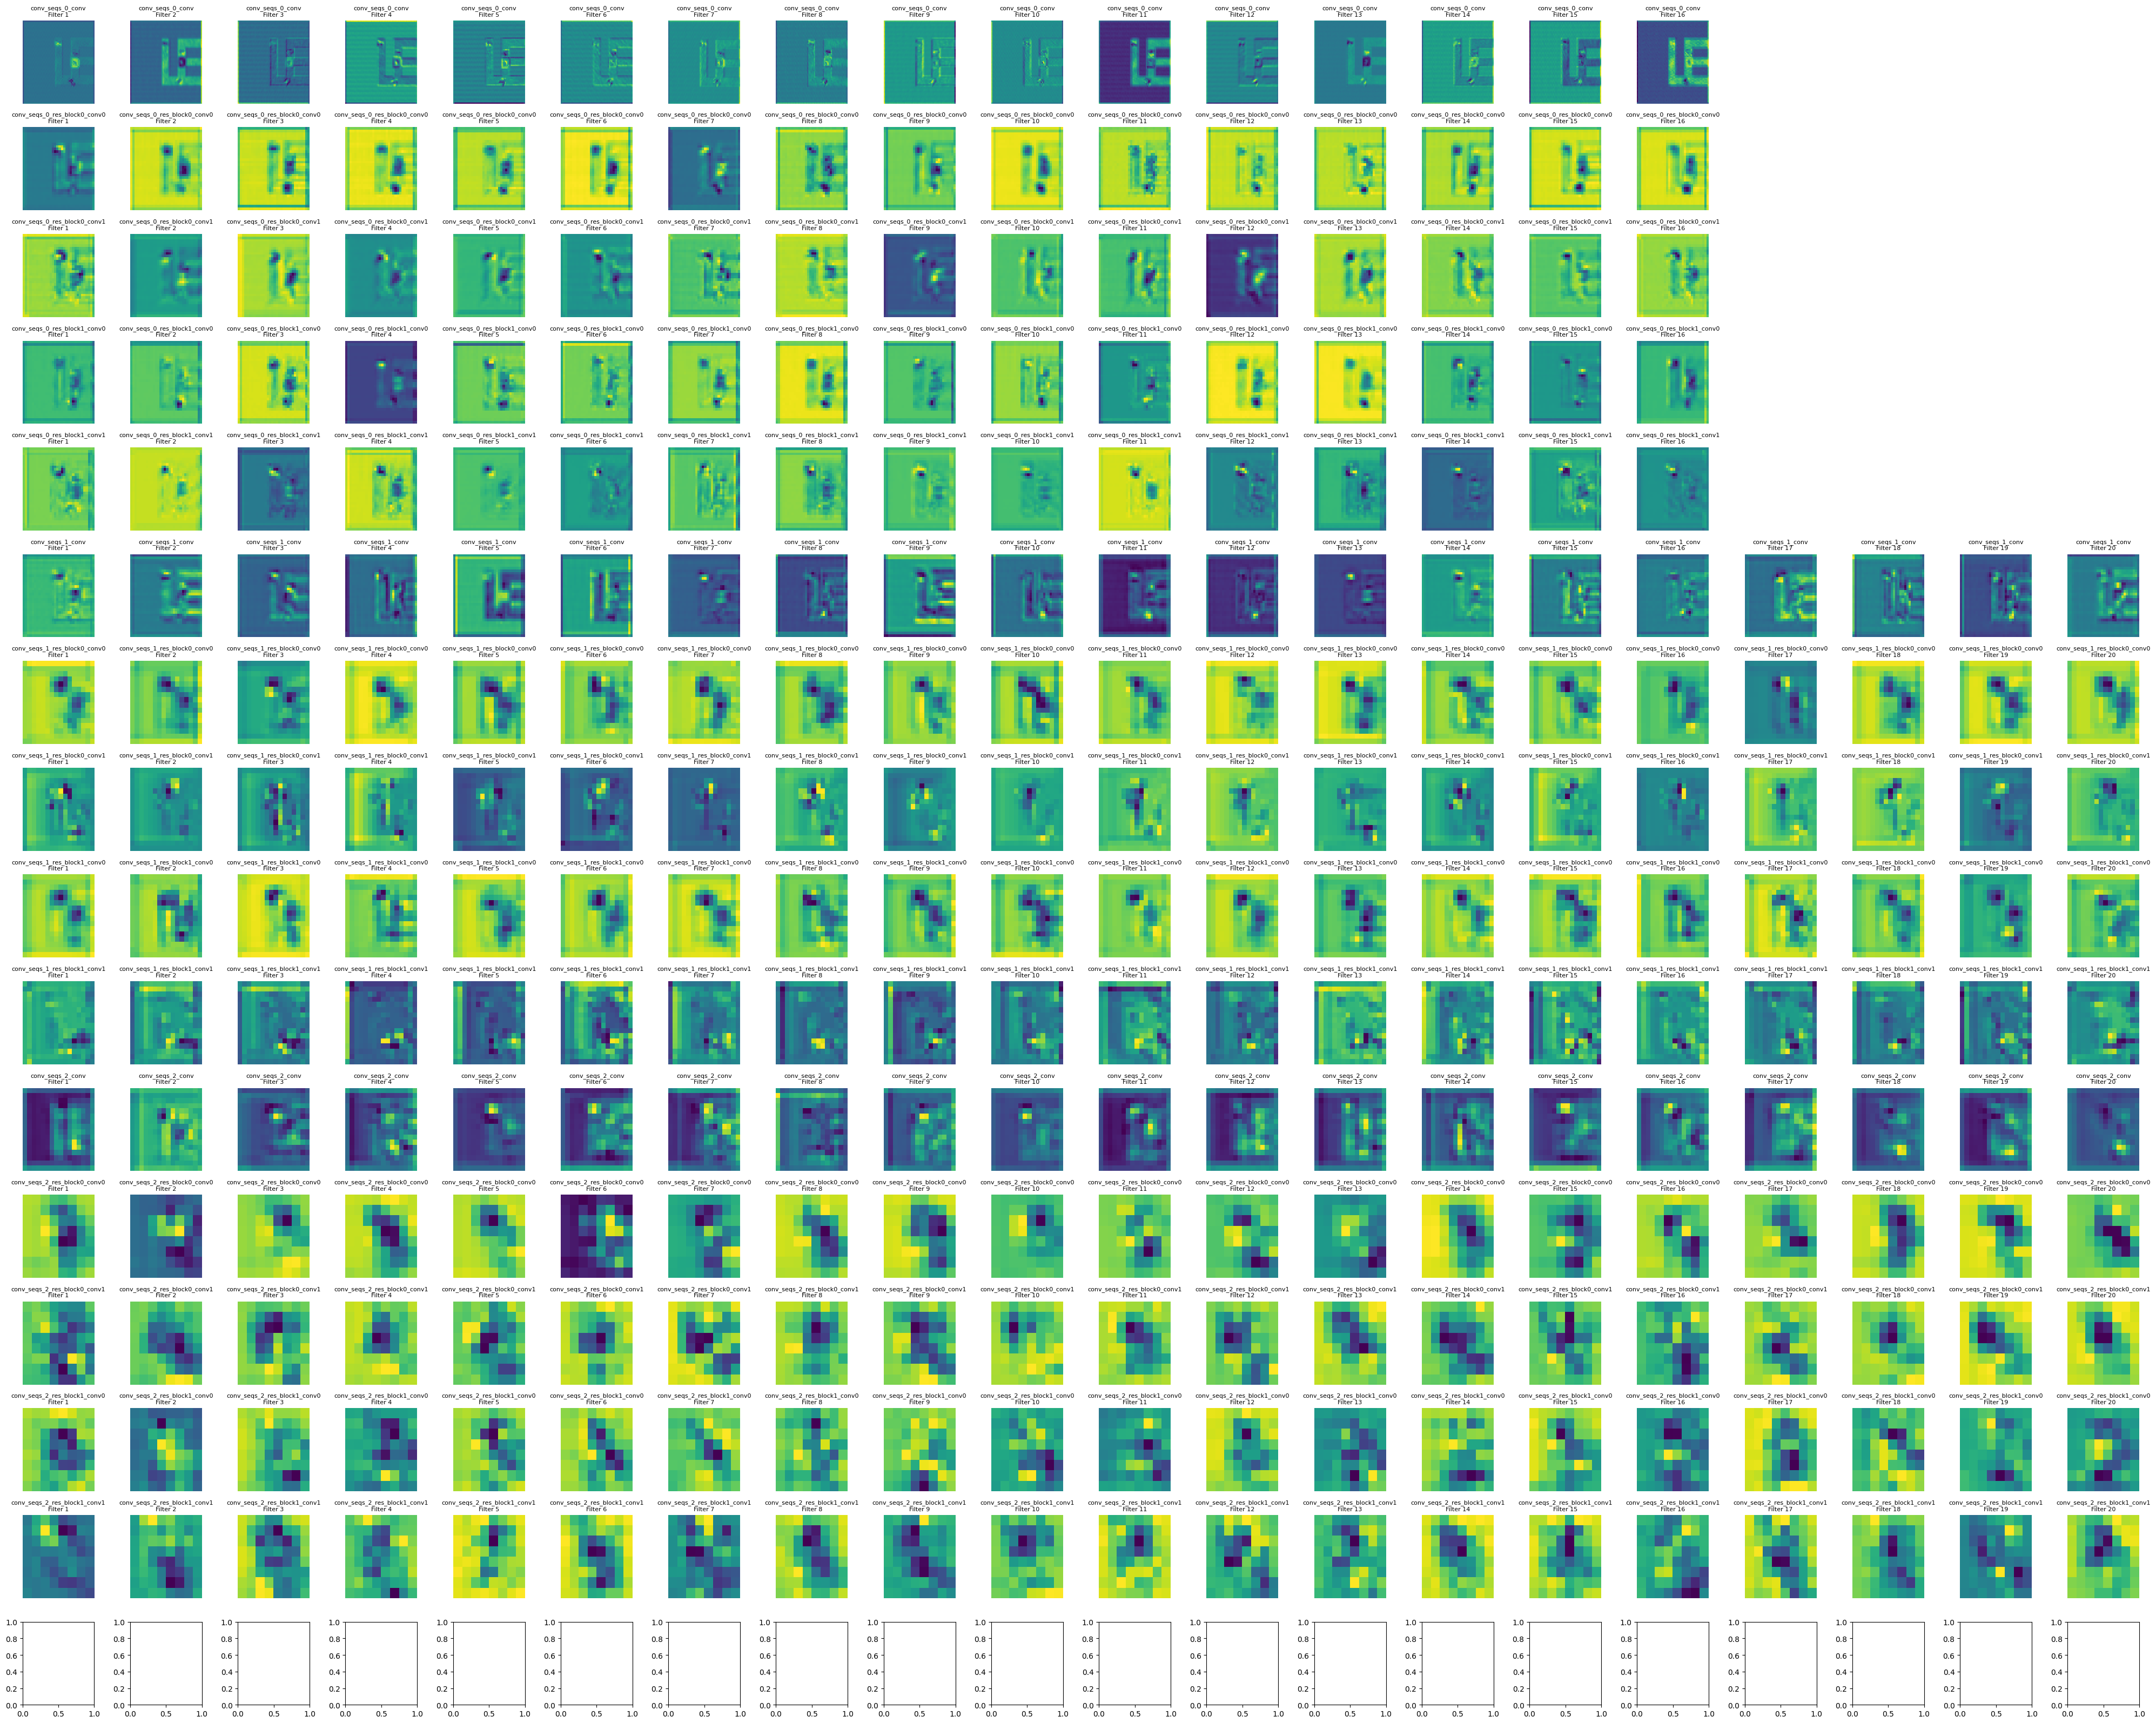

In [42]:
import matplotlib.pyplot as plt

def plot_all_layer_activations(activations, layer_names, max_cols=None):
    # Determine the maximum number of filters across the specified layers
    max_filters = 0
    for layer_name in layer_names:
        if layer_name in activations:
            tensor_shape = activations[layer_name][0].shape
            num_filters = tensor_shape[0] if len(tensor_shape) == 3 else tensor_shape[1]
            if num_filters > max_filters:
                max_filters = num_filters
    max_filters = min(max_filters, max_cols) if max_cols is not None else max_filters
    
    # Create a figure with subplots
    num_layers = len(layer_names)
    fig, axes = plt.subplots(num_layers, max_filters, figsize=(max_filters * 2, num_layers * 2))
    
    for i, layer_name in enumerate(layer_names):
        if layer_name not in activations:
            print(f"No activations found for layer: {layer_name}")
            continue
        
        activation_tensor = activations[layer_name][0].cpu().numpy()
        # Adjust for tensors that are 3D (missing batch dimension)
        if activation_tensor.ndim == 3:
            activation_tensor = activation_tensor[np.newaxis, :]  # Add a batch dimension
        
        num_filters = activation_tensor.shape[1]
        
        for j in range(max_filters):
            ax = axes[i, j] if num_layers > 1 else axes[j]
            if j < num_filters:
                # Plot the activation map for filter j
                ax.imshow(activation_tensor[0, j, :, :], cmap='viridis', aspect='auto')
                ax.set_title(f'{layer_name}\nFilter {j+1}', fontsize=8)
                ax.axis('off')
            else:
                # Hide axes without data
                ax.axis('off')
    
    plt.tight_layout()
    plt.show()

layer_names = [
    # 'conv_seqs_0_conv',
    # 'conv_seqs_0_res_block0_conv0',
    # 'conv_seqs_0_res_block0_conv1',
    # 'conv_seqs_0_res_block1_conv0',
    # 'conv_seqs_0_res_block1_conv1',
    'conv_seqs_1_conv',
    # 'conv_seqs_1_res_block0_conv0',
    # 'conv_seqs_1_res_block0_conv1',
    # 'conv_seqs_1_res_block1_conv0',
    # 'conv_seqs_1_res_block1_conv1',
    # 'conv_seqs_2_conv',
    # 'conv_seqs_2_res_block0_conv0',
    # 'conv_seqs_2_res_block0_conv1',
    # 'conv_seqs_2_res_block1_conv0',
    # 'conv_seqs_2_res_block1_conv1',
    # 'max_pool2d'
]


plot_all_layer_activations(activations, layers_to_visualize, max_cols=20)


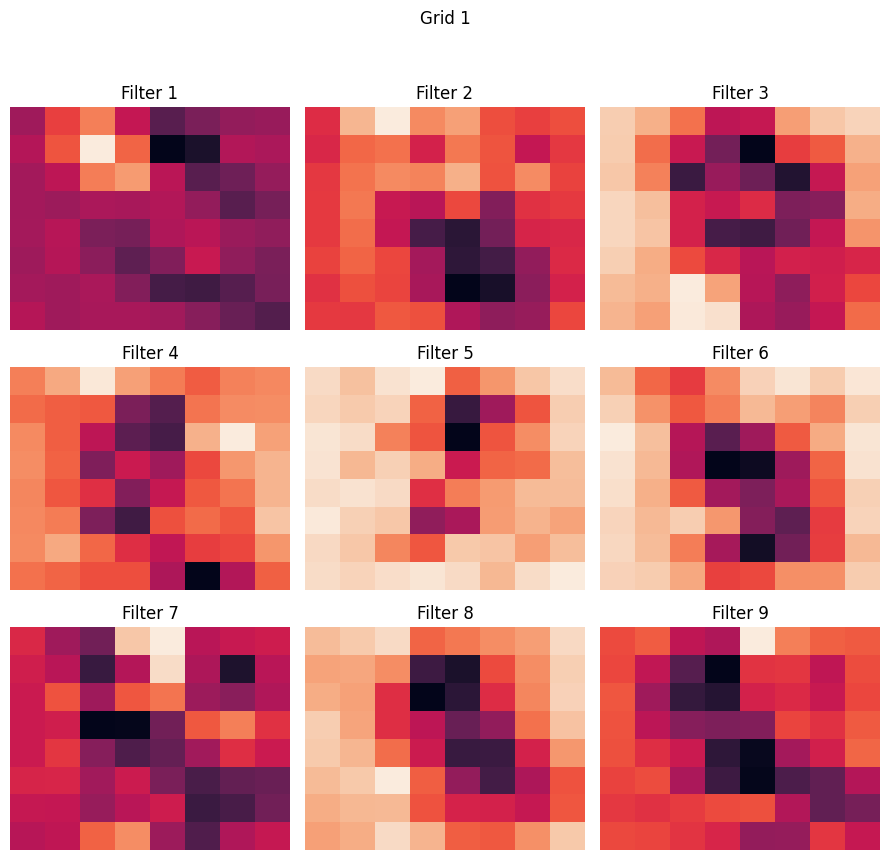

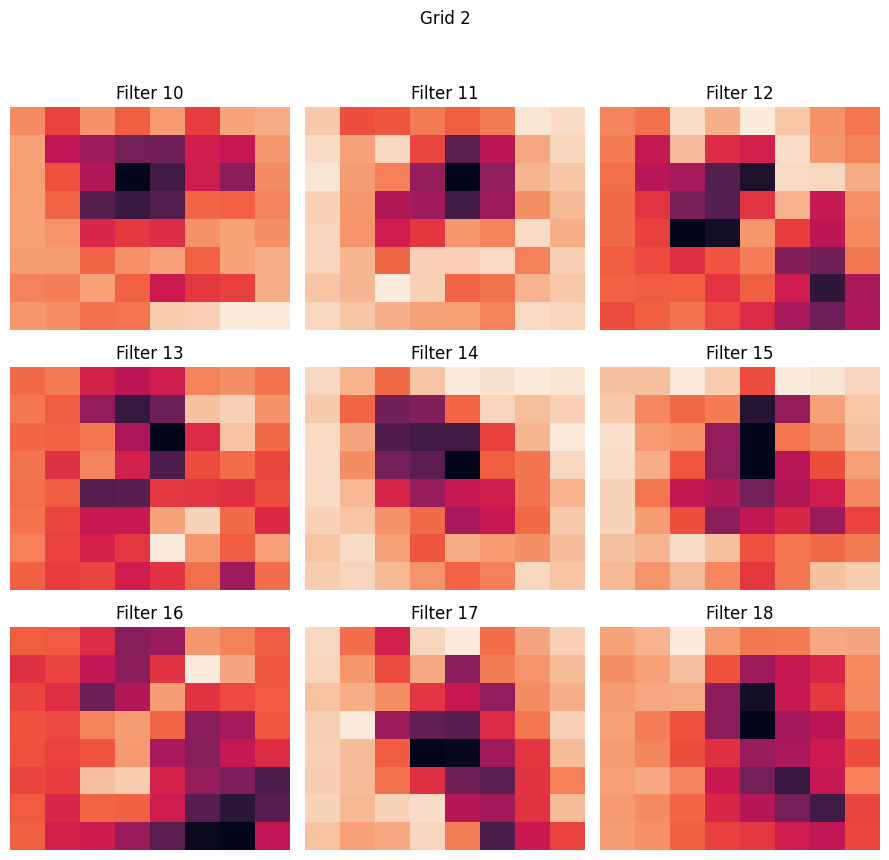

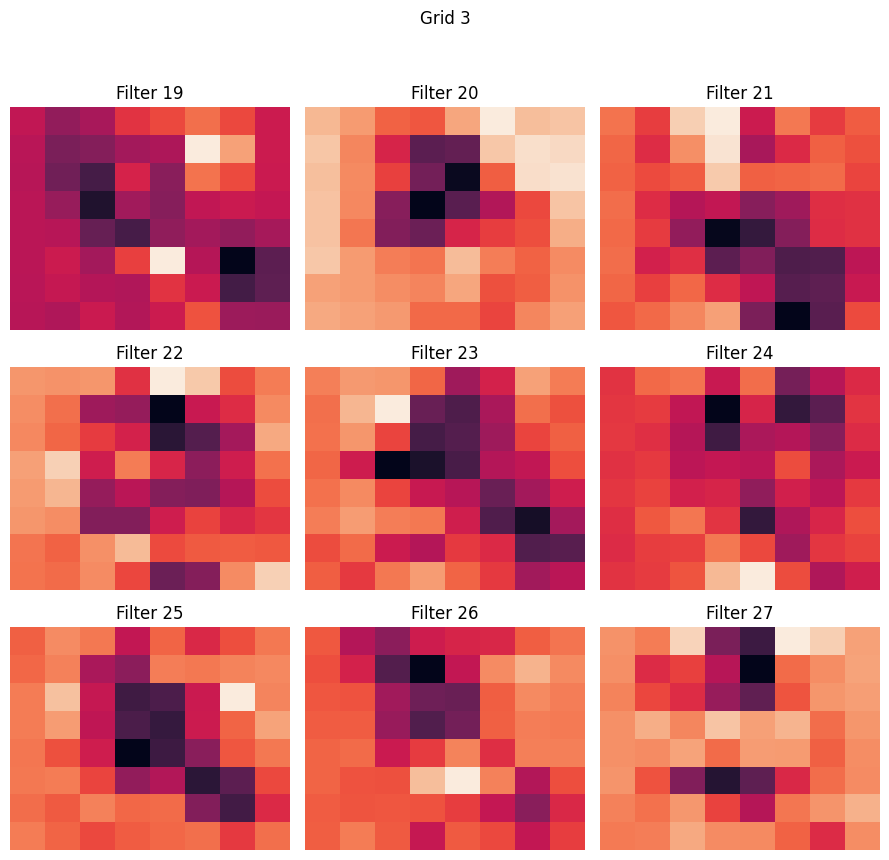

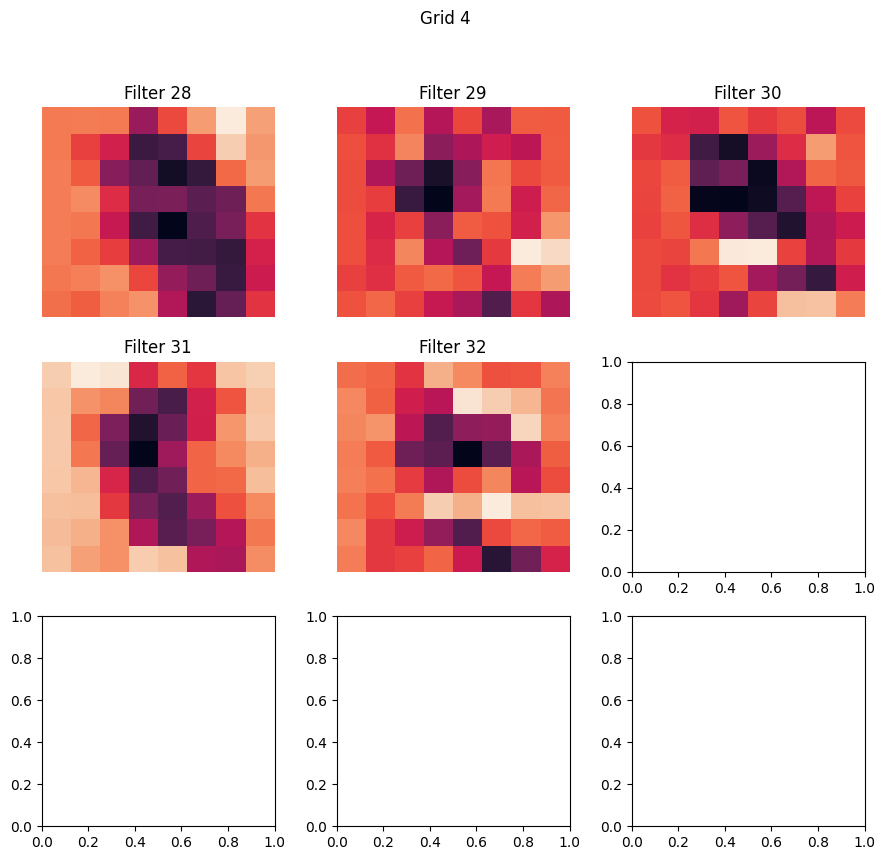

In [32]:

# Assuming activations_tensor is already defined and is a 4D tensor.
activations_tensor = activations['conv_seqs_2_res_block1_conv1'][0].cpu().numpy()

# Calculate the number of filters and determine how many 3x3 grids are needed
num_filters = activations_tensor.shape[0]
grids_needed = math.ceil(num_filters / 9)

# Iterate over all the grids needed
for grid_num in range(grids_needed):
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))  # Create a 3x3 grid
    fig.suptitle(f'Grid {grid_num + 1}')  # Title for each grid for clarity
    
    for i in range(9):  # Iterate over positions in the current 3x3 grid
        filter_idx = grid_num * 9 + i
        if filter_idx >= num_filters:  # Check if we've plotted all filters
            break  # Exit loop if all filters are plotted
        
        ax = axes[i // 3, i % 3]  # Determine the subplot position
        activation_map = activations_tensor[filter_idx, :, :]
        sns.heatmap(activation_map, ax=ax, cbar=False)
        ax.axis('off')  # Turn off the axis labels
        ax.set_title(f'Filter {filter_idx+1}')  # Set title to be the filter number
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [28]:
def plot_activations(activations, layer_name, num_cols=3):
    """Plots activation maps for the specified layer"""
    # Extract the activation tensor for the layer
    activation_tensor = activations[layer_name].cpu().numpy()
    
    # Determine the number of activation maps/filters
    num_activations = activation_tensor.shape[1]  # Assuming [batch, channels, height, width]
    
    # Calculate the number of rows needed in the grid
    num_rows = math.ceil(num_activations / num_cols)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    fig.suptitle(f'Activations for {layer_name}', fontsize=16)
    
    for i in range(num_rows * num_cols):
        row, col = divmod(i, num_cols)
        ax = axes[row, col] if num_rows > 1 else axes[col]
        
        if i < num_activations:
            # Plot the activation map
            sns.heatmap(activation_tensor[0, i, :, :], ax=ax, cbar=False)
            ax.set_title(f'Filter {i+1}')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide axes without data
    
    plt.tight_layout()
    plt.show()


In [29]:
# List of layer names you want to visualize
layers_to_visualize = [
    'conv_seqs_0_conv',
    'conv_seqs_1_conv',
    'conv_seqs_2_conv',
    # Add or remove layers based on your interest
]

for layer_name in layers_to_visualize:
    if layer_name in activations:
        plot_activations(activations, layer_name)
    else:
        print(f"No activations found for layer: {layer_name}")


AttributeError: 'tuple' object has no attribute 'cpu'

Exception ignored in: <function PluginV3.__del__ at 0x11f252b90>
Traceback (most recent call last):
  File "/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/imageio/core/v3_plugin_api.py", line 370, in __del__
    self.close()
  File "/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/imageio/plugins/pillow.py", line 144, in close
    self._flush_writer()
  File "/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/imageio/plugins/pillow.py", line 485, in _flush_writer
    primary_image.save(self._request.get_file(), **self.save_args)
  File "/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/PIL/Image.py", line 2439, in save
    save_handler(self, fp, filename)
  File "/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-

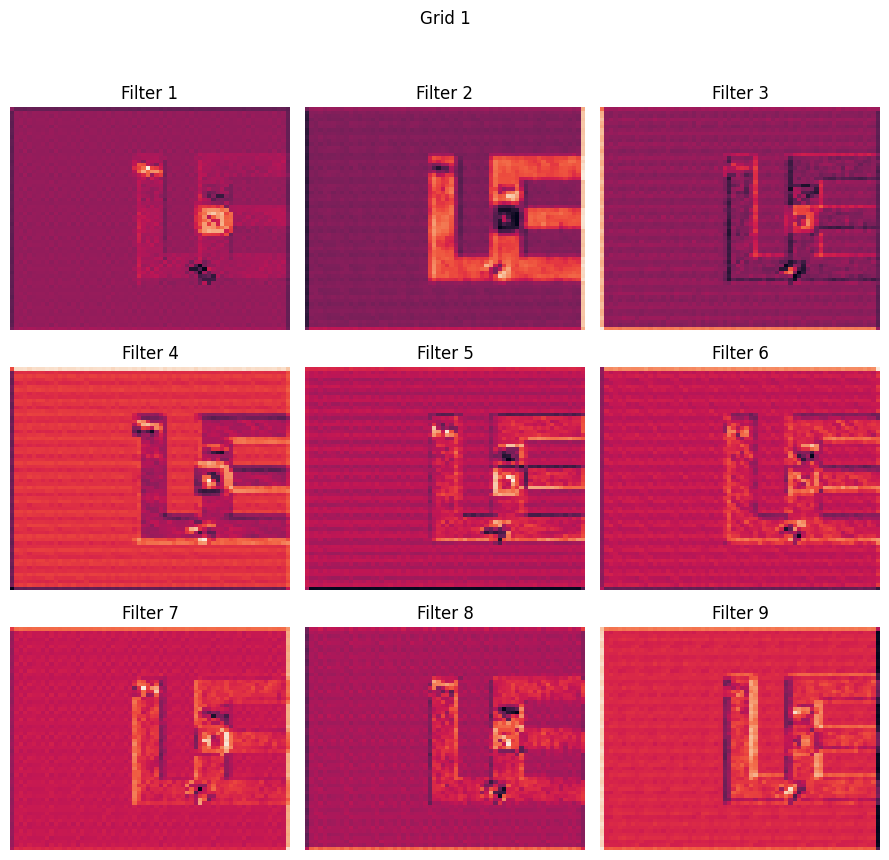

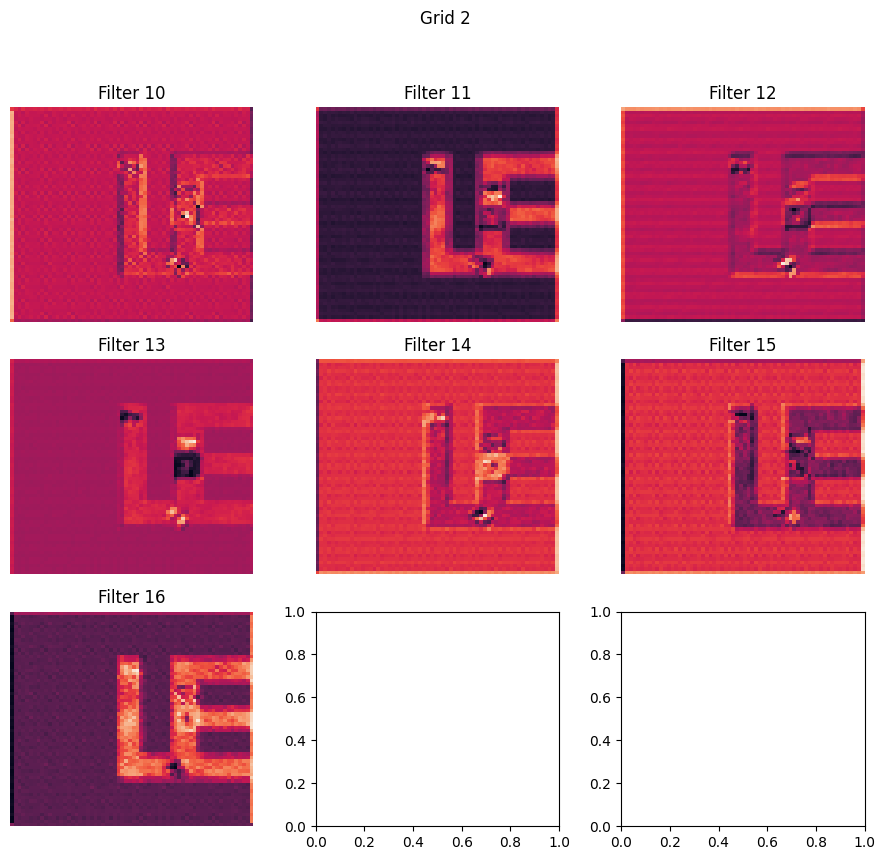

In [19]:


# Assuming activations_tensor is already defined and is a 4D tensor.
activations_tensor = activations['conv_seqs.0.conv'][0].cpu().numpy()

# Calculate the number of filters and determine how many 3x3 grids are needed
num_filters = activations_tensor.shape[0]
grids_needed = math.ceil(num_filters / 9)

# Iterate over all the grids needed
for grid_num in range(grids_needed):
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))  # Create a 3x3 grid
    fig.suptitle(f'Grid {grid_num + 1}')  # Title for each grid for clarity
    
    for i in range(9):  # Iterate over positions in the current 3x3 grid
        filter_idx = grid_num * 9 + i
        if filter_idx >= num_filters:  # Check if we've plotted all filters
            break  # Exit loop if all filters are plotted
        
        ax = axes[i // 3, i % 3]  # Determine the subplot position
        activation_map = activations_tensor[filter_idx, :, :]
        sns.heatmap(activation_map, ax=ax, cbar=False)
        ax.axis('off')  # Turn off the axis labels
        ax.set_title(f'Filter {filter_idx+1}')  # Set title to be the filter number
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [62]:
def get_model_layer_names(model):
    return [name for name, module in model.named_modules()]
names = get_model_layer_names(model)
print(names[:30])

['', 'conv_seqs', 'conv_seqs.0', 'conv_seqs.0.conv', 'conv_seqs.0.max_pool2d', 'conv_seqs.0.res_block0', 'conv_seqs.0.res_block0.conv0', 'conv_seqs.0.res_block0.conv1', 'conv_seqs.0.res_block1', 'conv_seqs.0.res_block1.conv0', 'conv_seqs.0.res_block1.conv1', 'conv_seqs.1', 'conv_seqs.1.conv', 'conv_seqs.1.max_pool2d', 'conv_seqs.1.res_block0', 'conv_seqs.1.res_block0.conv0', 'conv_seqs.1.res_block0.conv1', 'conv_seqs.1.res_block1', 'conv_seqs.1.res_block1.conv0', 'conv_seqs.1.res_block1.conv1', 'conv_seqs.2', 'conv_seqs.2.conv', 'conv_seqs.2.max_pool2d', 'conv_seqs.2.res_block0', 'conv_seqs.2.res_block0.conv0', 'conv_seqs.2.res_block0.conv1', 'conv_seqs.2.res_block1', 'conv_seqs.2.res_block1.conv0', 'conv_seqs.2.res_block1.conv1', 'hidden_fc']


In [25]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, shape: {param.size()}")

Parameter name: conv_seqs.0.conv.weight, shape: torch.Size([16, 3, 3, 3])
Parameter name: conv_seqs.0.conv.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block0.conv0.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block0.conv0.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block0.conv1.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block0.conv1.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block1.conv0.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block1.conv0.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block1.conv1.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block1.conv1.bias, shape: torch.Size([16])
Parameter name: conv_seqs.1.conv.weight, shape: torch.Size([32, 16, 3, 3])
Parameter name: conv_seqs.1.conv.bias, shape: torch.Size([32])
Parameter name: conv_seqs.1.res_block0.conv0.weight, shape: torch.Size([32, 3